# <center> Задача классификации об открытии депозита на основе данных банка

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from  sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import SelectKBest, f_classif

## Часть 1. Знакомство с данными, обработка пропусков и выбросов

### Задание 1

In [72]:
data = pd.read_csv('C:/Users/l340/Desktop/Skillfactory/ML/Project ML/bank_fin.csv', sep = ';')

In [16]:
# исследуйте данные на предмет пропусков. Где есть пропущенные значения? Сколько их?
# ваш код
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11137 non-null  object
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(6), object(11)
memory usage: 1.4+ MB


### Задание 2

In [17]:
# есть ли в признаке job пропущенные значения? Возможно, они обозначены каким-то специальным словом?
# ваш код
display(data)
data['education'].value_counts()

age          job  marital  education default       balance housing  \
0       59       admin.  married  secondary      no   2 343,00 $      yes   
1       56       admin.  married  secondary      no      45,00 $       no   
2       41   technician  married  secondary      no   1 270,00 $      yes   
3       55     services  married  secondary      no   2 476,00 $      yes   
4       54       admin.  married   tertiary      no     184,00 $       no   
...    ...          ...      ...        ...     ...           ...     ...   
11157   33  blue-collar   single    primary      no       1,00 $      yes   
11158   39     services  married  secondary      no     733,00 $       no   
11159   32   technician   single  secondary      no      29,00 $       no   
11160   43   technician  married  secondary      no         0  $       no   
11161   34   technician  married  secondary      no         0  $       no   

      loan   contact  day month  duration  campaign  pdays  previous poutcome  \
0       no   unknown    5   may      1042         1     -1         0  unknown   
1       no   unknown    5   may      1467         1     -1         0  unknown   
2       no   unknown    5   may      1389         1     -1         0  unknown   
3       no   unknown    5   may       579         1     -1         0  unknown   
4       no   unknown    5   may       673         2     -1         0  unknown   
...    ...       ...  ...   ...       ...       ...    ...       ...      ...   
11157   no  cellular   20   apr       257         1     -1         0  unknown   
11158   no   unknown   16   jun        83         4     -1         0  unknown   
11159   no  cellular   19   aug       156         2     -1         0  unknown   
11160  yes  cellular    8   may         9         2    172         5  failure   
11161   no  cellular    9   jul       628         1     -1         0  unknown   

      deposit  
0         yes  
1         yes  
2         yes  
3         yes  
4         yes  
...       ...  
11157      no  
11158      no  
11159      no  
11160      no  
11161      no  

[11162 rows x 17 columns]

education
secondary    5476
tertiary     3689
primary      1500
unknown       497
Name: count, dtype: int64

### Задание 3

В одну строку

In [18]:
#df['balance'] = data['balance'].apply(lambda x: x if [x]==[np.nan] else float((x.replace(' ', '')).replace(',', '.').split('$')[0]))

Через def

In [73]:
def process_balance(x):
    if pd.isna(x):
        return np.nan
    else:
        x_clean = x.replace(' ', '').replace(',', '.')
        x_split = x_clean.split('$')[0]
        return x_split
# Применение функции
data['balance'] = data['balance'].apply(process_balance)
data['balance'] = data['balance'].astype(float)

In [20]:
round(data['balance'].mean(),3)

np.float64(1529.129)

### Задание 4

In [74]:
# обработайте пропуски в признаки balance , заменив их на медианные значения по данному признаку
# ваш код
data['balance'] = data['balance'].fillna(data['balance'].median())
round(data['balance'].mean(),3)

np.float64(1526.936)

### Задание 5

In [75]:
# обработайте пропуски в категориальных признаках: job и education, заменив их на модальные значения
# ваш код
data['job'] = data['job'].apply(lambda x: x if x!='unknown' else data['job'].mode()[0])
data['education'] = data['education'].apply(lambda x: x if x!='unknown' else data['education'].mode()[0])

In [23]:
data['education'].value_counts()

education
secondary    5973
tertiary     3689
primary      1500
Name: count, dtype: int64

In [24]:
mask=(data['job']=='management') & (data['education']=='secondary')
round(data[mask]['balance'].mean(),3)

np.float64(1598.883)

### Задание 6

In [76]:
# удалите все выбросы для признака balance
# ваш код
# Метод межквартильного размаха (метод Тьюки)

def outliers_iqr(data, feature):
    x = data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x >= lower_bound) & (x <= upper_bound)]
    return outliers, cleaned,lower_bound,upper_bound

outliers, cleaned,a,b = outliers_iqr(data, 'balance')
print(a,b)
print(f'Число выбросов по методу Тьюки: {outliers.shape[0]}')
print(f'Результирующее число записей: {cleaned.shape[0]}')

-2241.0 4063.0
Число выбросов по методу Тьюки: 1057
Результирующее число записей: 10105


In [77]:
data=cleaned

## Часть 2:  Разведывательный анализ

### Задание 1

In [27]:
data['deposit'].value_counts()

deposit
no     5424
yes    4681
Name: count, dtype: int64

Text(0.5, 1.0, 'Распределение частоты для открывших депозит и для тех, кто его не открыл')

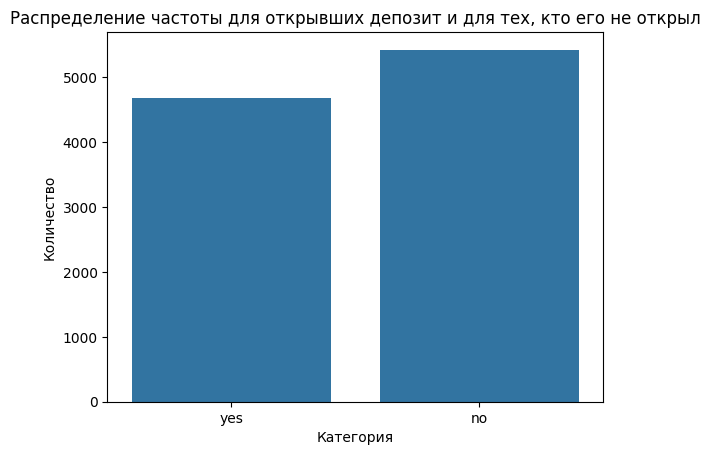

In [28]:
# изучите соотношение классов в ваших данных на предмет несбалансированности, проиллюстрируйте результат
# ваш код

sns.countplot(x='deposit',data=data)
plt.xlabel('Категория')
plt.ylabel('Количество')
plt.title('Распределение частоты для открывших депозит и для тех, кто его не открыл')



### Задания 2 и 3

In [29]:
#рассчитайте описательные статистики для количественных переменных, проинтерпретируйте результат
#ваш код
data.describe()# по умолчанию числовые


age       balance           day      duration      campaign  \
count  10105.000000  10105.000000  10105.000000  10105.000000  10105.000000   
mean      40.895497    807.653538     15.590302    368.742603      2.517170   
std       11.734931    994.151966      8.441510    346.651524      2.707159   
min       18.000000  -2049.000000      1.000000      2.000000      1.000000   
25%       32.000000     95.000000      8.000000    137.000000      1.000000   
50%       38.000000    445.000000     15.000000    252.000000      2.000000   
75%       48.000000   1227.000000     22.000000    490.000000      3.000000   
max       95.000000   4063.000000     31.000000   3881.000000     43.000000   

              pdays      previous  
count  10105.000000  10105.000000  
mean      51.319644      0.816230  
std      109.644179      2.243795  
min       -1.000000      0.000000  
25%       -1.000000      0.000000  
50%       -1.000000      0.000000  
75%        2.000000      1.000000  
max      854.000000     58.000000

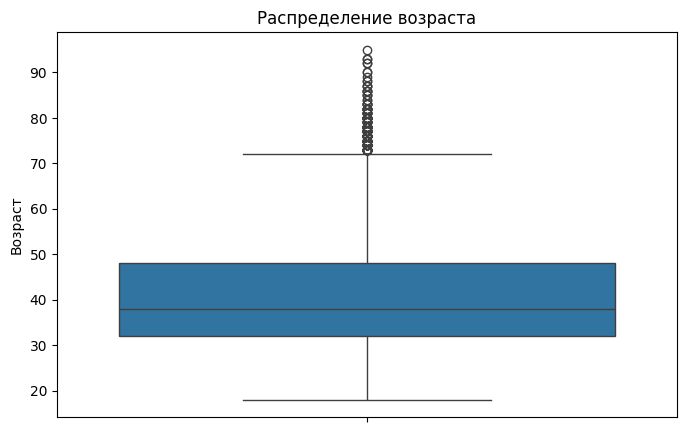

In [30]:
fig = plt.figure(figsize=(8, 5))
sns.boxplot(
    data=data,
    y='age'
    )
plt.title('Распределение возраста');
plt.ylabel('Возраст');


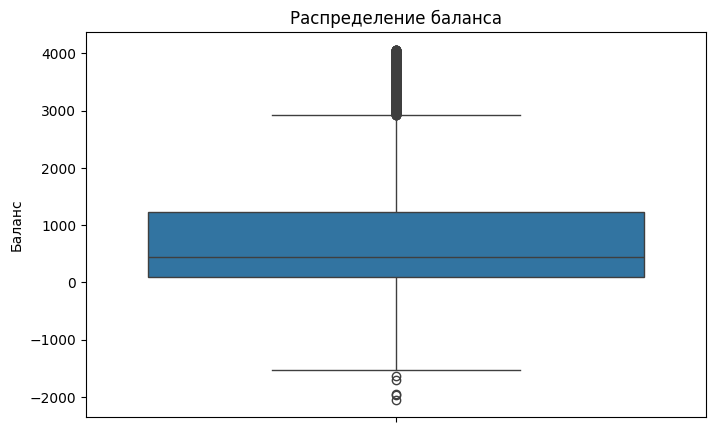

In [31]:
fig = plt.figure(figsize=(8, 5))
sns.boxplot(
    data=data,
    y='balance'
    )
plt.title('Распределение баланса');
plt.ylabel('Баланс');

### Задания 4 и 5

In [32]:
#рассчитайте описательные статистики для категориальных переменных, проинтерпретируйте результат
#ваш код
#постройте визуализации, иллюстрирующие результаты
data.describe(include='object')

job  marital  education default housing   loan   contact  \
count        10105    10105      10105   10105   10105  10105     10105   
unique          11        3          3       2       2      2         3   
top     management  married  secondary      no      no     no  cellular   
freq          2315     5715       5517    9939    5243   8712      7283   

        month poutcome deposit  
count   10105    10105   10105  
unique     12        4       2  
top       may  unknown      no  
freq     2617     7570    5424

### Задание 6

In [33]:
# Узнайте, для какого статуса предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач.
# ваш код
data['poutcome'].value_counts()

poutcome
unknown    7570
failure    1109
success     945
other       481
Name: count, dtype: int64

In [34]:
data['deposit'].value_counts()

deposit
no     5424
yes    4681
Name: count, dtype: int64

### Задание 7

In [78]:
data['deposit']=data['deposit'].apply(lambda x: 0 if x=='no' else 1)
data['deposit'].value_counts()

deposit
0    5424
1    4681
Name: count, dtype: int64

In [79]:
# Выполняем группировку один раз
grouped = data.groupby('month')['deposit']

# Общее число заявок по месяцам
total_requests = grouped.count()

# Число успешных депозитов по месяцам
successful_deposits = grouped.sum()

# Расчет процента отказов
percent_failure = round(
    (total_requests - successful_deposits) / total_requests * 100
)

# Сортируем по убыванию
percent_failure = percent_failure.sort_values(ascending=False)

print(f'В {percent_failure.index[0]} месяце больше всего отказывались от открытия депозита.')

В may месяце больше всего отказывались от открытия депозита.


In [80]:
import plotly
import plotly.express as px
fig = px.bar(data.pivot_table(# можно без values, чтобы просто посчитать кол-во строк
    index='month',    
    columns='deposit',
    aggfunc='size',# считает количество строк
    fill_value=0
).sort_index(ascending=False).reset_index(), x='month', y=[0,1],
             orientation='v',
             text_auto=True,
             barmode='group',
             title='Открытие депозитов(deposit) в разрезе месяца контакта с клиентом(month)')
fig.show()

In [82]:
# Группируем по 'month'
grouped = data.groupby('month')

# Создаем список для хранения результатов
lst = []

# Проходим по группам
for month_name, group in grouped:
    total_cases = len(group) # group — это подтаблица (под DataFrame), содержащая все строки из исходных данных, относящиеся к этому месяцу.
    failure_cases = len(group[group['deposit'] == '0'])
    ratio = failure_cases / total_cases if total_cases > 0 else 0
    lst.append({'month': month_name, 'failure_ratio': ratio})

df_ratios = pd.DataFrame(lst)

print(df_ratios)

   month  failure_ratio
0    apr            0.0
1    aug            0.0
2    dec            0.0
3    feb            0.0
4    jan            0.0
5    jul            0.0
6    jun            0.0
7    mar            0.0
8    may            0.0
9    nov            0.0
10   oct            0.0
11   sep            0.0


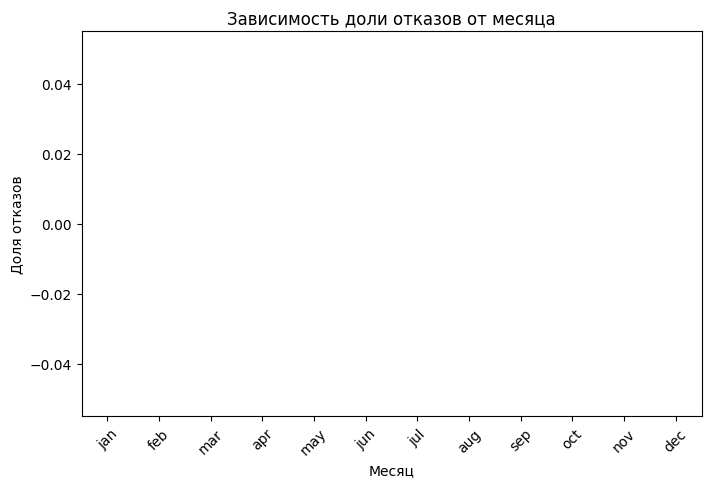

In [39]:
# узнайте, в каком месяце чаще всего отказывались от предложения открыть депозит
# ваш код

# Указываем порядок месяцев (если нужно)
months_order = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 
                'jul', 'aug', 'sep', 'oct', 'nov', 'dec']

# Преобразуем колонку в категориальный тип с порядком
df_ratios['month'] = pd.Categorical(df_ratios['month'], categories=months_order, ordered=True)
fig = plt.figure(figsize=(8, 5))
sns.barplot(
    data=df_ratios,
    x='month',
    y='failure_ratio'
    )
plt.xlabel('Месяц')
plt.ylabel('Доля отказов')
plt.title('Зависимость доли отказов от месяца')
plt.xticks(rotation=45)  # при необходимости повернуть подписи месяцев
plt.show()


### Задание 8

In [83]:
# создайте возрастные группы и определите, в каких группах более склонны открывать депозит, чем отказываться от предложения
def get_age(x):
    if x<30:
        return '<30'
    elif 30<=x<=40:
        return '30-40'
    elif 40<=x<=50:
        return '40-50'
    elif 50<=x<=60:
        return '50-60'
    elif x>60:
        return '60+'

data['age_group']=data['age'].apply(get_age)
data['age_group'].value_counts()

age_group
30-40    4257
40-50    2255
50-60    1625
<30      1455
60+       513
Name: count, dtype: int64

In [41]:
ct=pd.crosstab(data['age_group'],data['deposit'])


<Axes: xlabel='deposit', ylabel='age_group'>

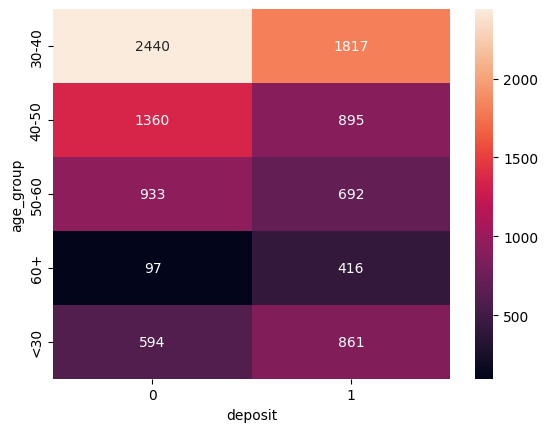

In [42]:
sns.heatmap(ct,annot=True,fmt='d')

### Задания 9 и 10

<Axes: xlabel='deposit', ylabel='marital'>

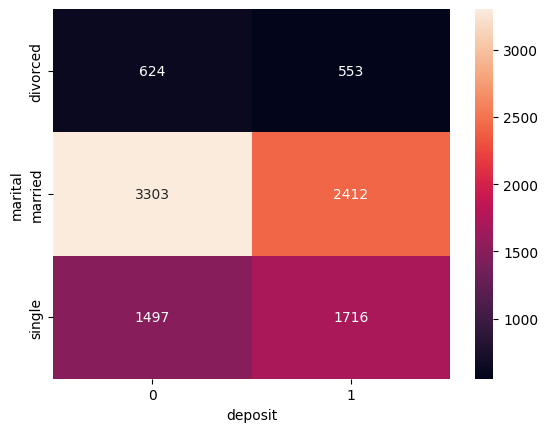

In [43]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от семейного статуса
ct=pd.crosstab(data['marital'],data['deposit'])
sns.heatmap(ct,annot=True,fmt='d')

<Axes: xlabel='deposit', ylabel='education'>

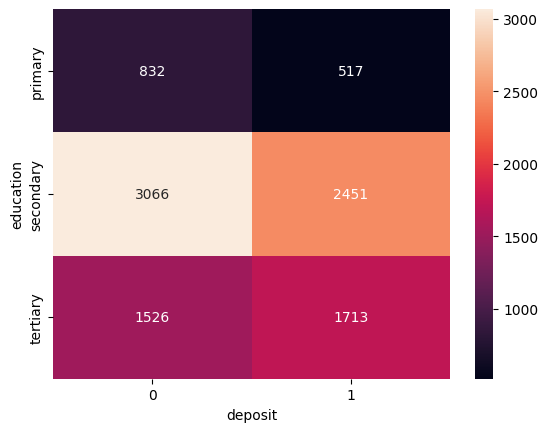

In [44]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от образования
ct=pd.crosstab(data['education'],data['deposit'])
sns.heatmap(ct,annot=True,fmt='d')

<Axes: xlabel='deposit', ylabel='job'>

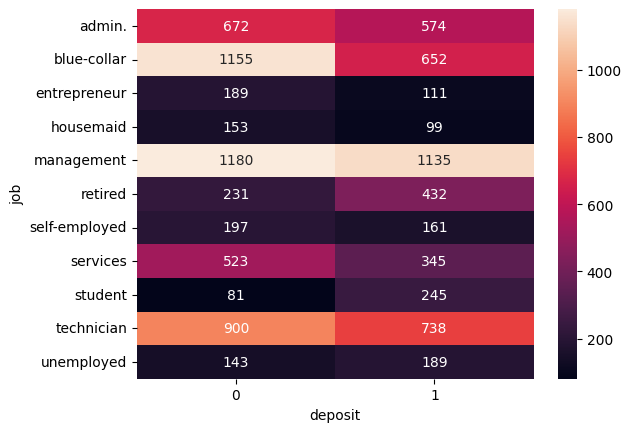

In [45]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от вида профессиональной занятости
ct=pd.crosstab(data['job'],data['deposit'])
sns.heatmap(ct,annot=True,fmt='d')

### Задание 11

<Axes: xlabel='education', ylabel='marital'>

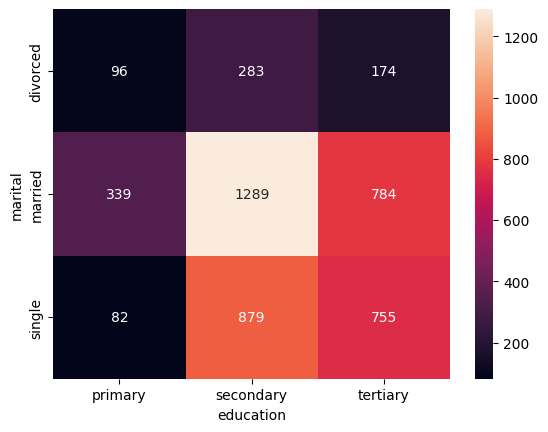

In [46]:
# постройте сводную таблицу, чтобы определить люди с каким образованием и семейным статусом наиболее многочисленны
#(если рассматривать тех, кто открыл депозит)
df=data[data['deposit']==1]
pvt=df.pivot_table(# можно без values, чтобы просто посчитать кол-во строк
    values='deposit',
    index='marital',    
    columns='education',
    aggfunc='count',
    fill_value=0
)
sns.heatmap(pvt,annot=True,fmt='d')

## Часть 3: преобразование данных

### Задание 1

In [84]:
# преобразуйте уровни образования
le=LabelEncoder()
data['education_cod']=le.fit_transform(data['education'])
data['education_cod'].sum()

np.int64(11995)

In [85]:
le=LabelEncoder()
data['age_cod']=le.fit_transform(data['age_group'])


### Задания 2 и 3

In [49]:
# преобразуйте бинарные переменные в представление из нулей и единиц
round(data['deposit'].std(),3) # стандартное отклонение

np.float64(0.499)

In [86]:
from sklearn.preprocessing  import LabelBinarizer
 
lb = LabelBinarizer()
data['default']=le.fit_transform(data['default'])

In [87]:
from sklearn.preprocessing  import LabelBinarizer
 
lb = LabelBinarizer()
data['housing']=le.fit_transform(data['housing'])

In [88]:
from sklearn.preprocessing  import LabelBinarizer
 
lb = LabelBinarizer()
data['loan']=le.fit_transform(data['loan'])

In [53]:
round(data['default'].mean()+data['housing'].mean()+data['loan'].mean(),3)

np.float64(0.635)

### Задание 4

In [89]:
# создайте дамми-переменные
data=pd.get_dummies(data,columns=['job',
'marital',
'contact',
'month',
'poutcome'])

data = data.drop(columns=['age', 'education', 'default', 'loan', 'housing','age_group'])

In [90]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10105 entries, 0 to 11161
Data columns (total 42 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   balance            10105 non-null  float64
 1   day                10105 non-null  int64  
 2   duration           10105 non-null  int64  
 3   campaign           10105 non-null  int64  
 4   pdays              10105 non-null  int64  
 5   previous           10105 non-null  int64  
 6   deposit            10105 non-null  int64  
 7   education_cod      10105 non-null  int64  
 8   age_cod            10105 non-null  int64  
 9   job_admin.         10105 non-null  bool   
 10  job_blue-collar    10105 non-null  bool   
 11  job_entrepreneur   10105 non-null  bool   
 12  job_housemaid      10105 non-null  bool   
 13  job_management     10105 non-null  bool   
 14  job_retired        10105 non-null  bool   
 15  job_self-employed  10105 non-null  bool   
 16  job_services       10105 no

### Задания 5 и 6

In [56]:
# постройте корреляционную матрицу и оцените данные на предмет наличия мультиколлинеарности
corr_matrix=data.corr(numeric_only=True)
deposit_matrix=corr_matrix['deposit'].drop('deposit')
deposit_matrix.sort_values(ascending=False)

duration             0.457818
poutcome_success     0.288491
contact_cellular     0.223944
pdays                0.147917
age_cod              0.141776
previous             0.141102
balance              0.135893
month_mar            0.135348
month_oct            0.130599
month_sep            0.125239
job_student          0.105563
job_retired          0.100090
education_cod        0.098253
marital_single       0.097005
month_apr            0.092888
month_dec            0.085041
month_feb            0.044728
poutcome_other       0.039319
job_unemployed       0.039196
job_management       0.029566
poutcome_failure     0.021124
contact_telephone    0.007064
marital_divorced     0.004808
job_admin.          -0.001927
job_self-employed   -0.005194
month_jun           -0.008533
job_technician      -0.011190
month_aug           -0.018225
job_housemaid       -0.022572
month_jan           -0.025847
month_nov           -0.027754
job_entrepreneur    -0.032706
job_services        -0.040433
month_jul 

### Задания 7 и 8

In [91]:
X = data.drop(['deposit'], axis=1)
y = data['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)
print(f'Размер тренировочной выборки:{X_train.shape}')
print(f'Размер тестовой выборки:{X_test.shape}')

Размер тренировочной выборки:(6770, 41)
Размер тестовой выборки:(3335, 41)


In [58]:
# рассчитайте необходимые показатели
y_test.mean()

np.float64(0.46326836581709147)

### Задание 9

In [59]:
# с помощью SelectKBest отберите 15 наиболее подходящих признаков
from sklearn.feature_selection import SelectKBest, f_classif

selector = SelectKBest(f_classif, k=15)
selector.fit(X_train, y_train)
 
selector.get_feature_names_out()

array(['balance', 'duration', 'campaign', 'pdays', 'previous', 'age_cod',
       'job_student', 'contact_cellular', 'contact_unknown', 'month_mar',
       'month_may', 'month_oct', 'month_sep', 'poutcome_success',
       'poutcome_unknown'], dtype=object)

### Задание 10

In [92]:
# нормализуйте данные с помощью minmaxsxaler
from sklearn.preprocessing import MinMaxScaler
scl=MinMaxScaler()
X_train_scl=scl.fit_transform(X_train)
X_train_scl=pd.DataFrame(X_train_scl,columns=X_train.columns)
X_test_scl=scl.fit_transform(X_test)
X_test_scl=pd.DataFrame(X_test_scl,columns=X_test.columns)

In [93]:
X_test_scl['day']

0       0.366667
1       0.900000
2       0.333333
3       0.600000
4       0.466667
          ...   
3330    0.966667
3331    0.966667
3332    0.166667
3333    0.933333
3334    0.100000
Name: day, Length: 3335, dtype: float64

# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

### Задание 1

In [94]:
# обучите логистическую регрессию и рассчитайте метрики качества
from sklearn import linear_model 
#Создаем объект класса логистическая регрессия
log_reg_full = linear_model.LogisticRegression(random_state=42, max_iter=1000,solver='sag')
#Обучаем модель, минизируя logloss
log_reg_full.fit(X_train_scl, y_train)
#Делаем предсказание класса
y_pred = log_reg_full.predict(X_test_scl)
print('Test accuracy score: {:.2f}'.format(metrics.accuracy_score(y_test, y_pred)))


Test accuracy score: 0.83


### Задания 2,3,4

In [101]:
# обучите решающие деревья, настройте максимальную глубину
from sklearn import tree
#Создаем объект класса логистическая регрессия
tree_reg = tree.DecisionTreeClassifier(random_state=42, criterion = 'entropy',max_depth=6)
#Обучаем модель, минизируя logloss
tree_reg.fit(X_train_scl, y_train)
#Делаем предсказание класса
y_pred = tree_reg.predict(X_test_scl)
print('Test accuracy score: {:.2f}'.format(metrics.accuracy_score(y_test, y_pred)))
#Делаем предсказание класса
y_train_pred = tree_reg.predict(X_train_scl)
print('Train accuracy score: {:.2f}'.format(metrics.accuracy_score(y_train, y_train_pred)))

Test accuracy score: 0.80
Train accuracy score: 0.82


### Задание 5

In [108]:
# подберите оптимальные параметры с помощью gridsearch
from sklearn.model_selection import GridSearchCV

param_grid = {'min_samples_split': [2, 5, 7, 10],'max_depth':[3,5,7]}
            
grid_search_tree = GridSearchCV(
    param_grid=param_grid,
    estimator=tree.DecisionTreeClassifier(random_state=42), 
    cv=5, 
    n_jobs = -1
    )

%time grid_search_tree.fit(X_train_scl, y_train) 
print("accuracy на тестовом наборе: {:.2f}".format(grid_search_tree.score(X_test_scl, y_test)))
y_test_pred = grid_search_tree.predict(X_test_scl)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search_tree.best_params_))

CPU times: total: 359 ms
Wall time: 6.1 s
accuracy на тестовом наборе: 0.80
f1_score на тестовом наборе: 0.80
Наилучшие значения гиперпараметров: {'max_depth': 7, 'min_samples_split': 2}


# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

### Задание 1

In [109]:
# обучите на ваших данных случайный лес
#Создаём объект класса случайный лес
rf_clf_2d = ensemble.RandomForestClassifier(
    n_estimators=100, #число деревьев
    criterion='gini', #критерий эффективности
    max_depth=10, #максимальная глубина дерева
    min_samples_leaf = 5, #число признаков из метода случайных подространств
    random_state=42 #генератор случайных чисел
)
#Обучаем модель 
rf_clf_2d.fit(X_train_scl, y_train)

#Делаем предсказание класса
y_pred = rf_clf_2d.predict(X_test_scl)
#Выводим отчёт о метриках
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.76      0.82      1790
           1       0.77      0.90      0.83      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.84      0.83      0.83      3335



### Задания 2 и 3

In [113]:
# используйте для классификации градиентный бустинг и сравните качество со случайным лесом
from sklearn.ensemble import GradientBoostingClassifier

# Создаем объект класса градиентный бустинг
gb = GradientBoostingClassifier(
    learning_rate = 0.05,
    max_depth=5,
    min_samples_leaf = 5, #максимальная глубина дерева
    n_estimators=300, #количество деревьев в ансамбле
    random_state=42 #датчик генератора случайных чисел
)

# Обучаем модель
gb.fit(X_train_scl, y_train)

# Формируем предсказание для тестовой выборки
gb_pred  = gb.predict(X_test_scl)

#Выводим отчёт о метриках
print(metrics.classification_report(y_test, gb_pred))

              precision    recall  f1-score   support

           0       0.91      0.77      0.84      1790
           1       0.78      0.92      0.84      1545

    accuracy                           0.84      3335
   macro avg       0.85      0.85      0.84      3335
weighted avg       0.85      0.84      0.84      3335



### Задание 4

In [119]:
# объедините уже известные вам алгоритмы с помощью стекинга 
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingRegressor
# Создаем список кортежей вида: (наименование модели, модель)
estimators = [
    ('rd', DecisionTreeClassifier(random_state=42, criterion = 'entropy',max_depth=6)),
    ('gb', GradientBoostingClassifier(
    learning_rate = 0.05,
    max_depth=5,
    min_samples_leaf = 5, #максимальная глубина дерева
    n_estimators=300, #количество деревьев в ансамбле
    random_state=42 #датчик генератора случайных чисел
))
]

# Создаем объект класса стекинг
reg = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(random_state=42, max_iter=1000,solver='sag')
)
# Обучаем модель
reg.fit(X_train_scl, y_train)
y_pred=reg.predict(X_test_scl)
#Выводим отчёт о метриках
print(metrics.classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.91      0.78      0.84      1790
           1       0.78      0.91      0.84      1545

    accuracy                           0.84      3335
   macro avg       0.85      0.85      0.84      3335
weighted avg       0.85      0.84      0.84      3335



### Задание 5

In [124]:
# оцените, какие признаки демонстрируют наибольшую  важность в модели градиентного бустинга

df = pd.DataFrame([gb.feature_importances_], columns=gb.feature_names_in_)
df.loc[0].sort_values(ascending=False)


duration             0.456134
poutcome_success     0.112952
contact_unknown      0.076114
day                  0.044851
pdays                0.044693
age_cod              0.040422
balance              0.034284
month_mar            0.026294
month_jun            0.019988
month_oct            0.017977
month_may            0.015635
month_apr            0.014323
month_sep            0.012250
month_jul            0.010697
month_nov            0.010170
campaign             0.008932
month_feb            0.008641
month_aug            0.004422
previous             0.004273
education_cod        0.004198
job_blue-collar      0.003608
contact_cellular     0.002742
poutcome_unknown     0.002562
marital_single       0.002480
marital_married      0.002273
month_dec            0.002237
month_jan            0.002224
job_student          0.002188
job_management       0.002072
job_retired          0.001766
job_admin.           0.001607
job_services         0.001178
poutcome_failure     0.001125
marital_di

### Задания 6,7,8

In [131]:
# реализуйте оптимизацию гиперпараметров с помощью Optuna
import optuna

def optuna_rf(trial):
  # задаем пространства поиска гиперпараметров
  n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
  max_depth = trial.suggest_int('max_depth', 10, 30, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

  # создаем модель
  model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=42)
  # обучаем модель
  model.fit(X_train_scl, y_train)
  score = metrics.f1_score(y_train, model.predict(X_train_scl))

  return score

In [132]:
%%time
# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=20)

[I 2025-05-27 18:00:13,833] A new study created in memory with name: RandomForestClassifier
[I 2025-05-27 18:00:15,639] Trial 0 finished with value: 0.9199814270236806 and parameters: {'n_estimators': 195, 'max_depth': 28, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.9199814270236806.
[I 2025-05-27 18:00:16,907] Trial 1 finished with value: 0.8878951426368543 and parameters: {'n_estimators': 144, 'max_depth': 23, 'min_samples_leaf': 6}. Best is trial 0 with value: 0.9199814270236806.
[I 2025-05-27 18:00:18,370] Trial 2 finished with value: 0.8770630880765078 and parameters: {'n_estimators': 182, 'max_depth': 25, 'min_samples_leaf': 8}. Best is trial 0 with value: 0.9199814270236806.
[I 2025-05-27 18:00:19,802] Trial 3 finished with value: 0.8734216199568833 and parameters: {'n_estimators': 200, 'max_depth': 30, 'min_samples_leaf': 9}. Best is trial 0 with value: 0.9199814270236806.
[I 2025-05-27 18:00:20,702] Trial 4 finished with value: 0.8805050816137974 and parameters: {'n_

CPU times: total: 23.3 s
Wall time: 23.5 s


In [133]:
# выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("f1_score на обучающем наборе: {:.2f}".format(study.best_value))

Наилучшие значения гиперпараметров {'n_estimators': 161, 'max_depth': 28, 'min_samples_leaf': 2}
f1_score на обучающем наборе: 0.95


In [ ]:
# рассчитаем точность для тестовой выборки
model = ensemble.RandomForestClassifier(**study.best_params,random_state=42 )
model.fit(X_train_scl, y_train)
y_train_pred = model.predict(X_train_scl)
print("accuracy на тестовом наборе: {:.2f}".format(model.score(X_test_scl, y_test)))
y_test_pred = model.predict(X_test_scl)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

accuracy на тестовом наборе: 0.84
f1_score на тестовом наборе: 0.84


In [6]:
import numpy as np
from sklearn.metrics import mean_squared_error

y_true = [1.23, 2.35, 2.75]
y_pred = [1.01, 12.3, 2.74]

# Вычисляем MSE (среднеквадратичную ошибку)
mse = mean_squared_error(y_true, y_pred)

# RMSE — это корень из MSE
rmse = np.sqrt(mse)

print("RMSE:", rmse)

RMSE: 5.746042116100439
